# Stock Price Forecasting: RNN & LSTM Networks (Part 3)

Author: **Marcin Sikorski**<br>
Date: March, 2024

This notebook will display close price estimations with two artificial neural networks:
* RNN (recurrent neural network),
* LSTM (long short-term memory).

**Notebook Content:**
1. Importing Dataset
2. Data Preprocessing & Splitting
3. Developing RNN Model
5. RNN Evaluation
6. Developing LSTM Model
7. LSTM Evaluation

### 1. Importing Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# set plotting style
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 9

# import dataset
df = pd.read_csv('mtd_prices.csv', parse_dates=['date'], index_col='date')
df.fillna(0, inplace=True)

df.sample(5)

,high,low,unix,cum_change,open,cma_7,sma_7_up,sma_7,sma_7_low,ema_14,b_ma,bu,bl,year,atr,close
date,,,,,,,,,,,,,,,,
2004-03-28,43.670001,43.206666,1080432000,2.407438,43.300001,34.763116,43.994146,42.612857,41.231567,42.597933,42.174667,43.392508,40.956825,2004,0.683602,43.470000
2010-09-19,124.796666,123.349998,1284854400,7.845946,123.843333,56.176500,125.547348,123.087143,120.626938,120.932859,119.173750,126.349743,111.997756,2010,2.194514,123.526667
2017-11-10,626.739990,618.979980,1510272000,29.770481,624.010010,136.994757,646.613736,630.571420,614.529104,643.739563,657.589552,701.904681,613.274424,2017,12.591466,622.659973
2017-04-26,515.109985,507.910004,1493164800,26.222912,510.010010,124.033180,516.991622,498.660004,480.328386,493.509666,486.379999,507.159302,465.600696,2017,6.953312,512.989990
2022-04-11,1373.650024,1336.819946,1649635200,73.675834,1370.750000,277.692169,1393.789609,1357.898560,1322.007510,1365.502287,1372.980166,1416.637250,1329.323082,2022,38.110880,1348.000000


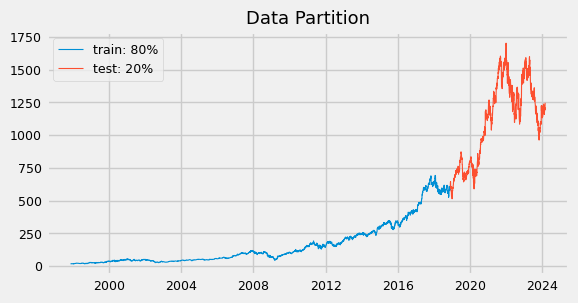

In [2]:
# split data by 80% training and 20% testing
cut_off = int(len(df) * 0.8)

train = df[:cut_off]
test = df[cut_off:]

# plot train / test split
plt.figure(figsize=(6, 3))

plt.plot(train['close'], label='train: 80%')
plt.plot(test['close'], label='test: 20%') 
plt.title('Data Partition')
plt.legend()

plt.show()

### 2. Data Preprocessing & Splitting

For RNN and LSTM regressors, the data needs appropriate transformations. We will reframe the dataset into a supervised form. This means we need to generate lag observations by shifting the target variable. We create copies of columns that are pushed forward (NaN rows are added to the front) or pulled back (NaN rows are added to the back). The augmentated dataset will be shorter by these *n* lags.

This time the dataset will be rescaled in range [0, 1]. We will keep the same split ratio 80/20.

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

# scale train dataset
scaled_train = scaler.fit_transform(train)

print('Train shape:', scaled_train.shape)

Train shape: (7683, 16)


In [4]:
X_train = []
y_train = []

prediction_step = 50

for i in range(prediction_step, cut_off):
    X_train.append(scaled_train[i - prediction_step:i, 0:scaled_train.shape[1]])
    y_train.append(scaled_train[i, 0])
    
# convert lists to arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape array - from (N,) to (N, 1)
y_train = np.reshape(y_train, (y_train.shape[0], 1))

print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)

X_train shape : (7633, 50, 16)
y_train shape : (7633, 1)


In [5]:
# scale test dataset
scaled_test = scaler.fit_transform(test)

print('Test shape:', scaled_test.shape)

Test shape: (1921, 16)


In [6]:
X_test = []
y_test = []

test_length = len(df) - cut_off

for i in range(prediction_step, test_length):
    X_test.append(scaled_test[i - prediction_step:i, 0:scaled_test.shape[1]])
    y_test.append(scaled_test[i, 0])

# convert lists to arrays
X_test, y_test = np.array(X_test), np.array(y_test)

# reshape array
y_test = np.reshape(y_test, (-1, 1))

print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_test shape : (1871, 50, 16)
y_test shape : (1871, 1)


In [7]:
# are there NaN values in arrays?
# NaN values will make model training fail
print('X_train:', np.isnan(X_train).any())
print('y_train:', np.isnan(y_train).any())
print('X_test:', np.isnan(X_test).any())
print('y_test:', np.isnan(y_test).any())

X_train: False
y_train: False
X_test: False
y_test: False


### 3. Developing RNN Model

In [8]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout

def get_rnn_model(params):
    '''
    Returns RNN model.
    '''
    # set architecture
    model = Sequential(
        [
            # 1st RNN layer and dropout regularization
            SimpleRNN(units=params['rnn_units'], activation=params['activation'], return_sequences=True,
                      input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(rate=params['dropout']),
            
            # 2nd layer
            SimpleRNN(units=params['rnn_units'], activation=params['activation'], return_sequences=True),
            Dropout(rate=params['dropout']),
            
            # 3rd layer
            SimpleRNN(units=params['rnn_units'], activation=params['activation'], return_sequences=True),
            Dropout(rate=params['dropout']),
            
            # 4th layer
            SimpleRNN(units=params['rnn_units']),
            Dropout(rate=params['dropout']),
            
            # output layer
            Dense(units=1)
            #Dense(units=y_train.shape[1]) # 1-size output
            
        ], name='RNN_model'
    )
    
    model.compile(optimizer=params['optimizer'], loss=params['loss'])
    
    return model

In [9]:
# define RNN parameters
rnn_params = {
    'loss': 'mean_squared_error',
    'metrics': ['mean_absolute_error'],
    'activation': 'tanh',
    'optimizer': 'adam',
    'dropout': 0.2,
    'rnn_units': 50,
    'epochs': 50,
    'batch_size': 32,
    'validation_split': 0.1
}

# create model instance
rnn_model = get_rnn_model(params=rnn_params)

rnn_model.summary()

Model: "RNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            3350      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                50

In [10]:
# fit the RNN
rnn_history = rnn_model.fit(
    x=X_train,
    y=y_train,
    epochs=rnn_params['epochs'],
    batch_size=rnn_params['batch_size'],
    verbose=1,
    callbacks=None
)

Epoch 1/50
239/239 [==============================] - 19s 57ms/step - loss: 0.2174
Epoch 2/50
239/239 [==============================] - 14s 60ms/step - loss: 0.0588
Epoch 3/50
239/239 [==============================] - 15s 62ms/step - loss: 0.0283
Epoch 4/50
239/239 [==============================] - 14s 60ms/step - loss: 0.0147
Epoch 5/50
239/239 [==============================] - 12s 49ms/step - loss: 0.0090
Epoch 6/50
239/239 [==============================] - 14s 59ms/step - loss: 0.0060
Epoch 7/50
239/239 [==============================] - 11s 48ms/step - loss: 0.0043
Epoch 8/50
239/239 [==============================] - 12s 48ms/step - loss: 0.0033
Epoch 9/50
239/239 [==============================] - 11s 45ms/step - loss: 0.0026
Epoch 10/50
239/239 [==============================] - 11s 47ms/step - loss: 0.0022
Epoch 11/50
239/239 [==============================] - 11s 45ms/step - loss: 0.0020
Epoch 12/50
239/239 [==============================] - 10s 43ms/step - loss: 0.0018
E

### 4. RNN Evaluation

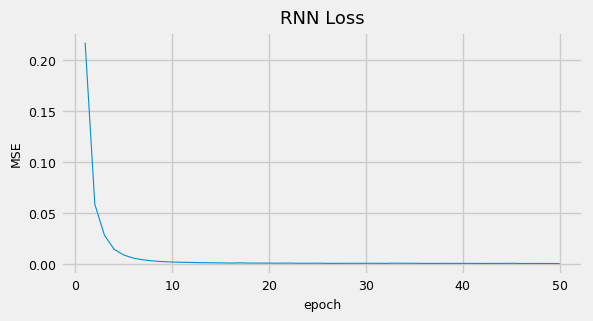

In [11]:
# plot learning process
plt.figure(figsize=(6, 3))

plt.plot(range(1, rnn_params['epochs'] + 1), rnn_history.history['loss'])
plt.title('RNN Loss')
plt.xlabel('epoch')
plt.ylabel('MSE')

plt.show()

We will make forecasts and rescale back the data to original range. Since we used 16 variables for transform, 1 target and 15 exogenous variables, the inverse expects same dimensions. Therefore, we will copy our values 16 times and discard them after inverse transform. The same processing will be performed on testing dataset to obtain the true prices.

In [12]:
# make predictions and rescale back from [0, 1] to original
rnn_predictions = rnn_model.predict(X_test)
prediction_copies = np.repeat(rnn_predictions, test.shape[1], axis=-1)

rnn_pred = scaler.inverse_transform(prediction_copies)[:, 0]

59/59 [==============================] - 1s 9ms/step


In [13]:
# rescale true values to original range
true_copies = np.repeat(y_test, test.shape[1], axis=-1)
true = scaler.inverse_transform(true_copies)[:, 0]

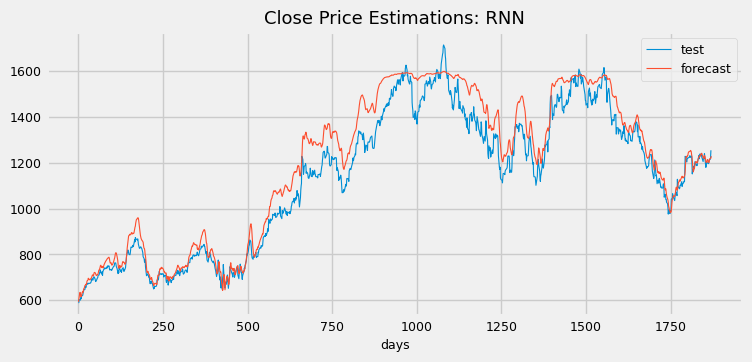

In [14]:
# plot predictions
plt.figure(figsize=(8, 3.5))

plt.plot(true, label='test')
plt.plot(rnn_pred, label='forecast')
plt.title('Close Price Estimations: RNN')
plt.xlabel('days')
plt.legend()

plt.show()

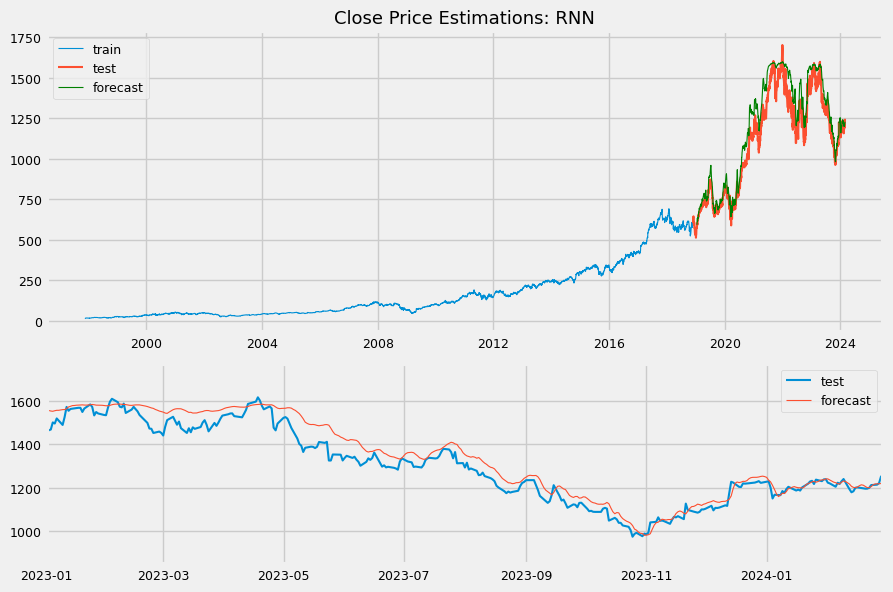

In [15]:
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(9, 6), tight_layout=True, gridspec_kw={'height_ratios': [1.5, 1]})

axes[0].plot(train['close'], label='train')
axes[0].plot(test['close'], linewidth=1.5, label='test')
axes[0].plot(test[prediction_step:].index, rnn_pred, color='green', label='forecast')
axes[0].set_title('Close Price Estimations: RNN')
axes[0].legend()

# zoomed view
axes[1].plot(test[prediction_step:].index, true, linewidth=1.5, label='test')
axes[1].plot(test[prediction_step:].index, rnn_pred, label='forecast')
axes[1].set_xlim(pd.Timestamp('2023-01-01'), test.index[-1])
axes[1].set_ylim(850)
axes[1].legend()

plt.show()

In [16]:
# join arrays
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

In [17]:
from sklearn.model_selection import KFold

rnn_cv_scores = []

def cross_val_rnn(k=6):
    '''
    Returns k-fold cross-validation score (RMSE) for RNN.
    '''
    kfold = KFold(n_splits=k, shuffle=False)
        
    fold_num = 1
    for train, test in kfold.split(inputs, targets):
        rnn_mod = get_rnn_model(params=rnn_params)
        
        print('-------------------------------------------------------------')
        print(f'Training for {fold_num}-fold:')
        
        rnn_mod.fit(
            x=inputs[train],
            y=targets[train],
            epochs=rnn_params['epochs'],
            batch_size=rnn_params['batch_size'],
            verbose=0)
        
        predictions = rnn_mod.predict(inputs[test], verbose=0)
        
        rmse = np.sqrt(((targets[test] - predictions)**2).mean())
        print('RMSE: {:.4f}'.format(rmse))
        rnn_cv_scores.append(rmse)
            
        # increase fold number
        fold_num = fold_num + 1
        
cross_val_rnn(k=6)

-------------------------------------------------------------
Training for 1-fold:
RMSE: 0.0109
-------------------------------------------------------------
Training for 2-fold:
RMSE: 0.0035
-------------------------------------------------------------
Training for 3-fold:
RMSE: 0.0038
-------------------------------------------------------------
Training for 4-fold:
RMSE: 0.0151
-------------------------------------------------------------
Training for 5-fold:
RMSE: 0.0327
-------------------------------------------------------------
Training for 6-fold:
RMSE: 0.0695


In [18]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(true, rnn_pred))
cv_rmse = sum(rnn_cv_scores)/6
r2 = r2_score(true, rnn_pred)
mae = mean_absolute_error(true, rnn_pred)
mape = mean_absolute_percentage_error(true, rnn_pred)

print('Testing performance:')
print('--------------------')
print('RMSE: {:.4f}'.format(rmse))
print('6-fold CV: {:.4f}'.format(cv_rmse))
print('R2: {:.4f}'.format(r2))
print('MAE: {:.4f}'.format(mae))
print('MAPE: {:.4f}%'.format(mape))

Testing performance:
--------------------
RMSE: 81.5023
6-fold CV: 0.0226
R2: 0.9257
MAE: 64.9433
MAPE: 0.0556%


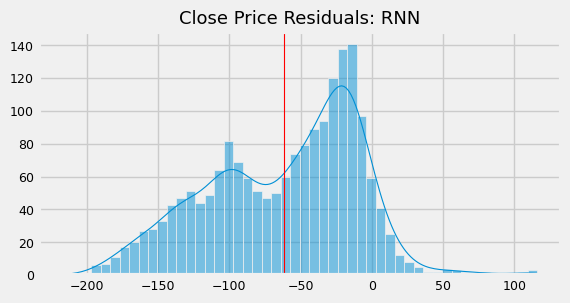

In [19]:
from seaborn import histplot

rnn_resid = true - rnn_pred

# plot residuals
plt.figure(figsize=(6, 3))

histplot(x=rnn_resid, kde=True, bins=50)
plt.axvline(x=rnn_resid.mean(), color='red') # plot mean value
plt.title('Close Price Residuals: RNN')
plt.xlabel(None)
plt.ylabel(None)

plt.show()

This time-series predictor is useless. The evaluation scores are not promising and the predicted price line does not overlap the true line at all. These residuals have a very uneven, trimodal distribution with highly negative skewness. We will try another model which is more sophisticated in terms of architecture and flow of information through the unit.

### 5. Developing LSTM Model

In [20]:
from keras.layers import LSTM

def get_lstm_model(params):
    '''
    Returns LSTM model.
    '''
    # set architecture
    model = Sequential(
        [
            # 1st LSTM layer
            LSTM(units=params['lstm_units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            
            # 2nd layer
            LSTM(units=params['lstm_units'], return_sequences=False),
            
            Dense(units=32),
            
            # output layer
            Dense(units=1)
            #Dense(units=y_train.shape[1]) # 1-size output
            
        ], name='LSTM_model'
    )
    
    model.compile(optimizer=params['optimizer'], loss=params['loss'])
    
    return model

In [21]:
# define LSTM parameters
lstm_params = {
    'loss': 'mean_squared_error',
    'metrics': ['mean_absolute_error'],
    'optimizer': 'adam',
    'lstm_units': 64,
    'epochs': 20,
    'batch_size': 10,
    'validation_split': 0.1
}

# create model instance
lstm_model = get_lstm_model(params=lstm_params)

lstm_model.summary()

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 64)            20736     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 55,873
Trainable params: 55,873
Non-trainable params: 0
_________________________________________________________________


In [22]:
# fit the LSTM
lstm_history = lstm_model.fit(
    x=X_train,
    y=y_train,
    epochs=lstm_params['epochs'],
    batch_size=lstm_params['batch_size'],
    verbose=1,
    callbacks=None
)

Epoch 1/20
762/762 [==============================] - 37s 42ms/step - loss: 0.0011
Epoch 2/20
762/762 [==============================] - 35s 46ms/step - loss: 1.3722e-04
Epoch 3/20
762/762 [==============================] - 34s 45ms/step - loss: 1.1460e-04
Epoch 4/20
762/762 [==============================] - 33s 44ms/step - loss: 1.3177e-04
Epoch 5/20
762/762 [==============================] - 34s 45ms/step - loss: 6.8651e-05
Epoch 6/20
762/762 [==============================] - 33s 43ms/step - loss: 1.4250e-04
Epoch 7/20
762/762 [==============================] - 34s 45ms/step - loss: 5.2482e-05
Epoch 8/20
762/762 [==============================] - 33s 43ms/step - loss: 7.2700e-05
Epoch 9/20
762/762 [==============================] - 40s 52ms/step - loss: 3.2111e-05
Epoch 10/20
762/762 [==============================] - 33s 44ms/step - loss: 4.6846e-05
Epoch 11/20
762/762 [==============================] - 37s 49ms/step - loss: 3.5130e-05
Epoch 12/20
762/762 [========================

### 6. LSTM Evaluation

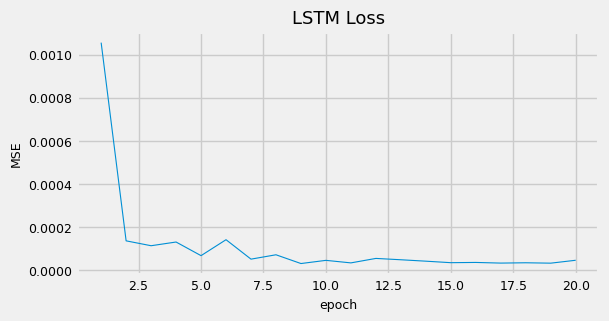

In [23]:
# plot learning process
plt.figure(figsize=(6, 3))

plt.plot(range(1, lstm_params['epochs'] + 1), lstm_history.history['loss'])
plt.title('LSTM Loss')
plt.xlabel('epoch')
plt.ylabel('MSE')

plt.show()

In [24]:
# make predictions and rescale back from [0, 1] to original
lstm_predictions = lstm_model.predict(X_test)
prediction_copies = np.repeat(lstm_predictions, test.shape[1], axis=-1)

lstm_pred = scaler.inverse_transform(prediction_copies)[:, 0]

59/59 [==============================] - 3s 28ms/step


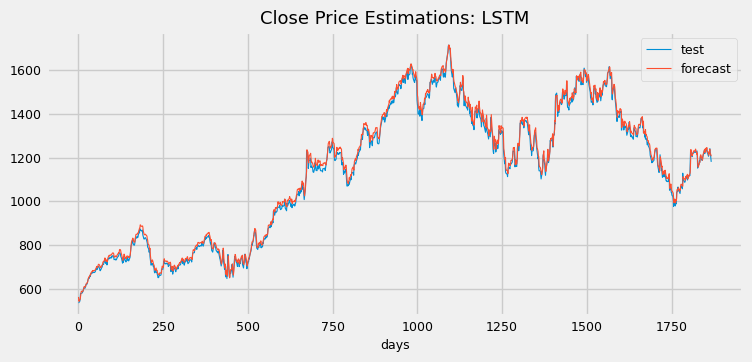

In [25]:
# plot predictions
plt.figure(figsize=(8, 3.5))

plt.plot(true, label='test')
plt.plot(lstm_pred, label='forecast')
plt.title('Close Price Estimations: LSTM')
plt.xlabel('days')
plt.legend()

plt.show()

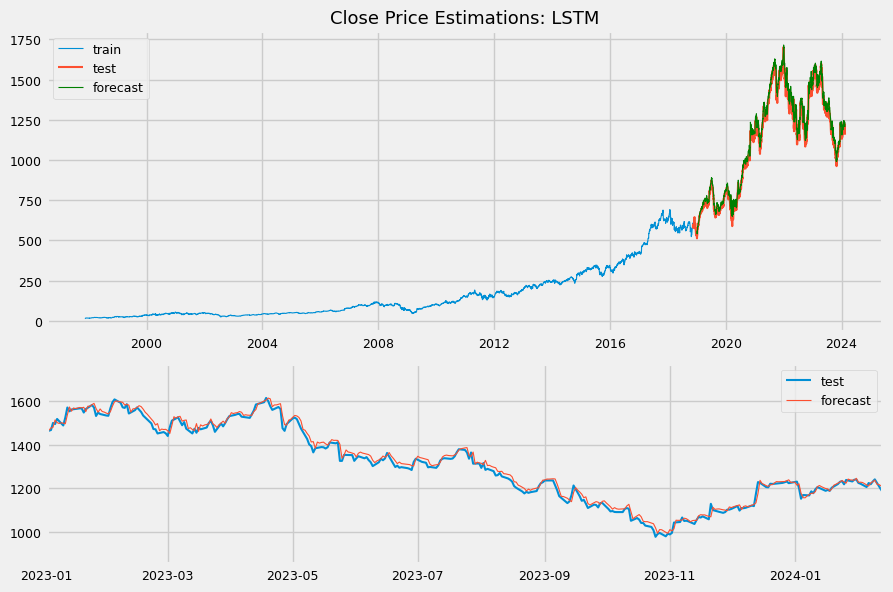

In [26]:
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(9, 6), tight_layout=True, gridspec_kw={'height_ratios': [1.5, 1]})

axes[0].plot(train['close'], label='train')
axes[0].plot(test['close'], linewidth=1.5, label='test')
axes[0].plot(test[prediction_step:].index, lstm_pred, color='green', label='forecast')
axes[0].set_title('Close Price Estimations: LSTM')
axes[0].legend()

# zoomed view
axes[1].plot(test[prediction_step:].index, true, linewidth=1.5, label='test')
axes[1].plot(test[prediction_step:].index, lstm_pred, label='forecast')
axes[1].set_xlim(pd.Timestamp('2023-01-01'), test.index[-1])
axes[1].set_ylim(850)
axes[1].legend()

plt.show()

In [27]:
# join arrays
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

In [28]:
lstm_cv_scores = []

def cross_val_lstm(k=6):
    '''
    Returns k-fold cross-validation score (RMSE) for LSTM.
    '''
    kfold = KFold(n_splits=k, shuffle=False)
        
    fold_num = 1
    for train, test in kfold.split(inputs, targets):
        lstm_mod = get_lstm_model(params=lstm_params)
        
        print('-------------------------------------------------------------')
        print(f'Training for {fold_num}-fold:')
        
        lstm_mod.fit(
            x=inputs[train],
            y=targets[train],
            epochs=lstm_params['epochs'],
            batch_size=lstm_params['batch_size'],
            verbose=0)
        
        predictions = lstm_mod.predict(inputs[test], verbose=0)
        
        rmse = np.sqrt(((targets[test] - predictions)**2).mean())
        print('RMSE: {:.4f}'.format(rmse))
        lstm_cv_scores.append(rmse)
            
        # increase fold number
        fold_num = fold_num + 1
        
cross_val_lstm(k=6)

-------------------------------------------------------------
Training for 1-fold:
RMSE: 0.0050
-------------------------------------------------------------
Training for 2-fold:
RMSE: 0.0008
-------------------------------------------------------------
Training for 3-fold:
RMSE: 0.0029
-------------------------------------------------------------
Training for 4-fold:
RMSE: 0.0033
-------------------------------------------------------------
Training for 5-fold:
RMSE: 0.0132
-------------------------------------------------------------
Training for 6-fold:
RMSE: 0.0170


In [29]:
rmse = np.sqrt(mean_squared_error(true, lstm_pred))
cv_rmse = sum(lstm_cv_scores)/6
r2 = r2_score(true, lstm_pred)
mae = mean_absolute_error(true, lstm_pred)
mape = mean_absolute_percentage_error(true, lstm_pred)

print('Testing performance:')
print('--------------------')
print('RMSE: {:.4f}'.format(rmse))
print('6-fold CV: {:.4f}'.format(cv_rmse))
print('R2: {:.4f}'.format(r2))
print('MAE: {:.4f}'.format(mae))
print('MAPE: {:.4f}%'.format(mape))

Testing performance:
--------------------
RMSE: 19.4527
6-fold CV: 0.0071
R2: 0.9959
MAE: 16.1197
MAPE: 0.0147%


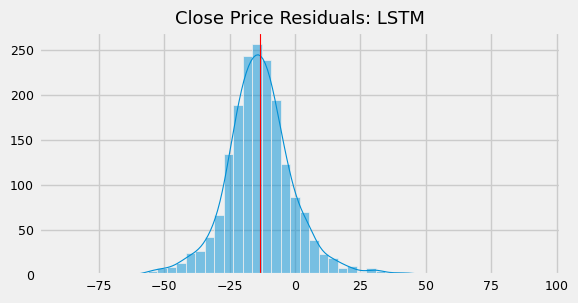

In [30]:
lstm_resid = true - lstm_pred

# plot residuals
plt.figure(figsize=(6, 3))

histplot(x=lstm_resid, kde=True, bins=50)
plt.axvline(x=lstm_resid.mean(), color='red') # plot mean value
plt.title('Close Price Residuals: LSTM')
plt.xlabel(None)
plt.ylabel(None)

plt.show()

This network is much more reasonable then the previous RNN model. The residuals are much evenly distributed with a negative skewness. The positive residuals are greater due to the fact that the forecasted line is shifted higher then the true line. The network's memory cells have higher ability to capture and process sequential information more effectively than the traditional RNN.

To be continued. Next notebook will display the Facebook's Prophet model as our next estimator.